In [6]:
import pandas as pd
from sklearn.metrics import f1_score

from lbl2vec import Lbl2Vec, Lbl2TransformerVec

from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

import spacy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [7]:
def get_spacy_similar_words_for_dataset(dataset_name, save_cache=False):
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')

    class_keywords = labels_df['class_keywords'].values.tolist()

    spacy_similarity_model = spacy.load('en_core_web_lg')
    resulting_keywords = {}

    all_documents_words = []
    for doc in documents_df[documents_df['dataset_type'] == 'train']['document']:
        all_documents_words.extend(doc.split(' '))
    all_documents_words = list(set(all_documents_words))

    for class_keyword in class_keywords:
        print(f'[INFO] Processing class keywords: {class_keyword}...' + ' ' * 20, end='\r')

        similarity_levels = []
        
        for word in all_documents_words:
            spacy_word_1 = spacy_similarity_model(word)
            spacy_word_2 = spacy_similarity_model(class_keyword)

            if(not (spacy_word_1 and spacy_word_1.vector_norm and spacy_word_2 and spacy_word_2.vector_norm)):
                continue
            similarity_level = spacy_word_1.similarity(spacy_word_2)

            similarity_levels.append((word, similarity_level))

        similarity_levels = sorted(similarity_levels, key=lambda x: x[1], reverse=True)
        resulting_keywords[class_keyword] = [word for word, _ in similarity_levels]
        
    if save_cache:
        cache_df = pd.DataFrame()
        cache_df['class_raw_keywords'] = labels_df['class_keywords']
        cache_df['class_result_keywords'] = resulting_keywords.values()
        cache_df.to_csv(f'cache/{dataset_name}_spacy_keywords.csv', index=False)

    return resulting_keywords

In [8]:
# for dataset_name in ['BBC_News', '20NewsGroup', 'DBLP', 'M10']:
#     get_spacy_similar_words_for_dataset(dataset_name, save_cache=True)

In [11]:
def evaluate_lbl2vec_on_dataset(dataset_name: str, n_iterations: int = 20, n_words: int = 1):
    def tokenize(doc):
        return simple_preprocess(strip_tags(doc), deacc=True, min_len=2, max_len=15)
    
    # -- Documents
    documents_df = pd.read_csv(f'../datasets/data/{dataset_name}/documents.csv')
    documents_df['tagged_docs'] = documents_df.apply(
        lambda row: TaggedDocument(tokenize(row['document']), [str(row.name)]), axis=1
    )
    documents_df['doc_key'] = documents_df.index.astype(str)

    # -- Labels
    labels_df = pd.read_csv(f'../datasets/data/{dataset_name}/labels.csv')
    labels_df['number_of_keywords'] = labels_df['class_keywords'].apply(lambda keywords: len(keywords))

    keywords_cached_df = pd.read_csv(f'cache/{dataset_name}_spacy_keywords.csv')
    keywords_cached_df['class_result_keywords'] = keywords_cached_df['class_result_keywords'].apply(lambda x: x[1:-1].replace("'", '').split(', '))
    similar_keywords = dict(zip(keywords_cached_df['class_raw_keywords'], keywords_cached_df['class_result_keywords']))
    labels_df['class_keywords'] = labels_df.apply(
        lambda row: similar_keywords[row['class_keywords']][:n_words], axis=1
    )

    # -- Model
    lbl2vec_model = Lbl2Vec(
        keywords_list=[item for item in labels_df['class_keywords']], 
        tagged_documents=list(documents_df['tagged_docs'][documents_df['dataset_type'] == 'train']), 
        label_names=list(labels_df['class_name']),
        min_count=2,
        verbose=False
    )
    lbl2vec_model.fit()

    # -- Evaluation
    avg_f1_score_train = 0
    avg_f1_score_test = 0

    for i in range(n_iterations):
        print(f'[INFO] Iteration {i+1}/{n_iterations}...' + ' ' * 20, end='\r')

        train_docs_lbl_similarities = lbl2vec_model.predict_model_docs()
        test_docs_lbl_similarities = lbl2vec_model.predict_new_docs(tagged_docs=documents_df['tagged_docs'][documents_df['dataset_type'] == 'test'])

        evaluation_train = train_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='train'], left_on='doc_key', right_on='doc_key')
        evaluation_test = test_docs_lbl_similarities.merge(documents_df[documents_df['dataset_type']=='test'], left_on='doc_key', right_on='doc_key')

        y_true_train = evaluation_train['class_name']
        y_pred_train = evaluation_train['most_similar_label']

        y_true_test = evaluation_test['class_name']
        y_pred_test = evaluation_test['most_similar_label']

        avg_f1_score_train += f1_score(y_true_train, y_pred_train, average='micro')
        avg_f1_score_test += f1_score(y_true_test, y_pred_test, average='micro')

    avg_f1_score_train /= n_iterations
    avg_f1_score_test /= n_iterations

    return avg_f1_score_train, avg_f1_score_test

In [14]:
n_words_used = [1, 10, 20, 60, 100]
colors = ['blue', 'red', 'green', 'orange']

results_df = pd.DataFrame()

for i, dataset_names in enumerate(['BBC_News', '20NewsGroup', 'DBLP', 'M10']):
    for n_words in n_words_used:
        current_train_scores, current_test_scores = evaluate_lbl2vec_on_dataset(dataset_names, n_words=n_words)

        results_df = pd.concat([
            results_df, 
            pd.DataFrame({
                'dataset': dataset_names,
                'n_words': n_words,
                'train_score': current_train_scores,
                'test_score': current_test_scores
            }, index=[0])
        ])

results_df

KeyboardInterrupt: 

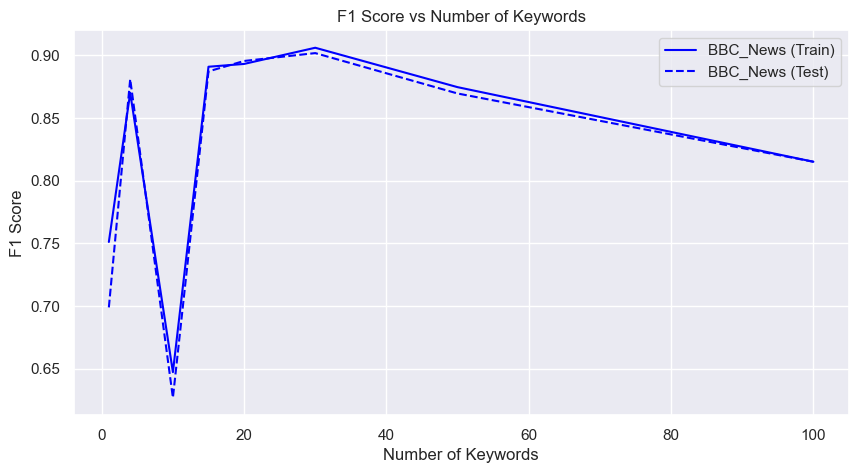

In [13]:
plt.figure(figsize=(10, 5))

n_words_used = [1, 10, 20, 40, 70, 100]
colors = ['blue', 'red', 'green', 'orange']

for i, dataset_names in enumerate(['BBC_News', '20NewsGroup', 'DBLP', 'M10']):
    train_scores, test_scores = [], []

    for n_words in n_words_used:
        current_train_scores, current_test_scores = evaluate_lbl2vec_on_dataset(dataset_names, n_words=n_words)

        train_scores.append(current_train_scores)
        test_scores.append(current_test_scores)

    plt.plot(n_words_used, train_scores, label=f'{dataset_names} (Train)', color=colors[i])
    plt.plot(n_words_used, test_scores, label=f'{dataset_names} (Test)', color=colors[i], linestyle='dashed')

plt.title('F1 Score vs Number of Keywords')
plt.xlabel('Number of Keywords')
plt.ylabel('F1 Score')
plt.legend()
plt.savefig('../figures/f1_score_vs_keywords_number.png', dpi=300)
plt.show()